# Interacting AMMs Model - Single AMM & Constant Market Price

On this Notebook, we'll explore a single instance of a Uniswap V2 AMM for a single pair of tokens that are associated with a constant market price.

Notice: all prices are expressed in terms of token 2 per token 1. For a AMM: Price = Token 2 Reserve / Token 1 Reserve

## Dependences & Setup

In [1]:
%load_ext autotime

time: 124 µs (started: 2021-05-10 17:50:45 -03:00)


In [2]:
import sys
sys.path.append("..")

time: 184 µs (started: 2021-05-10 17:50:45 -03:00)


In [3]:
import plotly.express as px
import pandas as pd
import plotly.io as pio
pio.renderers.default = "jupyterlab"

time: 277 ms (started: 2021-05-10 17:50:45 -03:00)


## Simulation Execution

In [4]:
from cadCAD_tools import easy_run

from interacting_amm_model import initial_state, params
from interacting_amm_model import timestep_block, N_timesteps, N_samples
from interacting_amm_model.model import sweep_params

results = (easy_run(initial_state,
                    params,
                    timestep_block,
                    N_timesteps,
                    N_samples,
                    assign_params=sweep_params)
           .reset_index())


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 27
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (150, 6, 5, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26]
SubsetIDs: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 

## Analytics

In [5]:
print(f"Sweeped parameters: {sweep_params}")

from interacting_amm_model.model import amms

for amm in amms.values():
    amm_df = pd.DataFrame(results.pair_state
                          .map(lambda s: s[amm.label])
                          .tolist()
                          )

    amm_df = amm_df.add_prefix(f"{amm.label}_")
    results = results.join(amm_df)

print(f"Available AMMs: {amms.keys()}")
print("---")

Sweeped parameters: {'arbitrage_intensity', 'positive_direction_bias', 'swap_vs_liquidity_preference', 'user_action_intensity'}
Available AMMs: dict_keys(['uniswap'])
---
time: 59.9 ms (started: 2021-05-10 17:50:47 -03:00)


In [6]:
df = (results.assign(amm_price=lambda df: df.uniswap_reserve_token_2 / df.uniswap_reserve_token_1)
             .assign(error=lambda df: df.market_price - df.amm_price)
             .assign(squared_error=lambda df: df.error ** 2)
            )

time: 2.01 ms (started: 2021-05-10 17:50:47 -03:00)


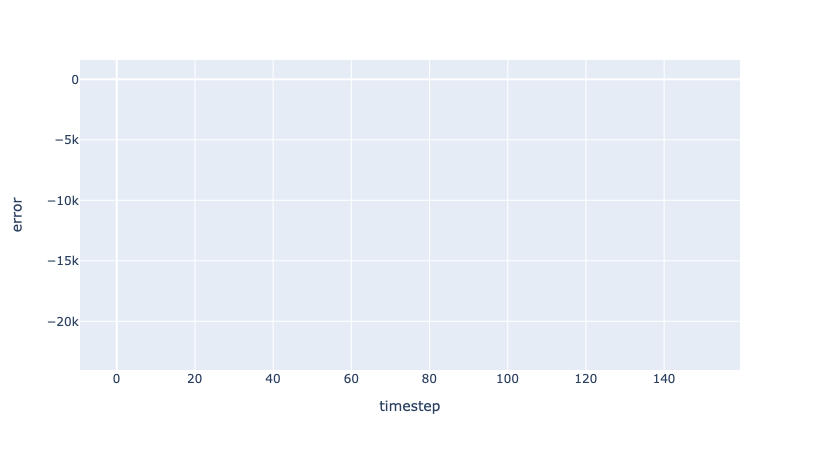

time: 277 ms (started: 2021-05-10 17:50:47 -03:00)


In [7]:
px.scatter(df, 
           x='timestep',
           y='error')

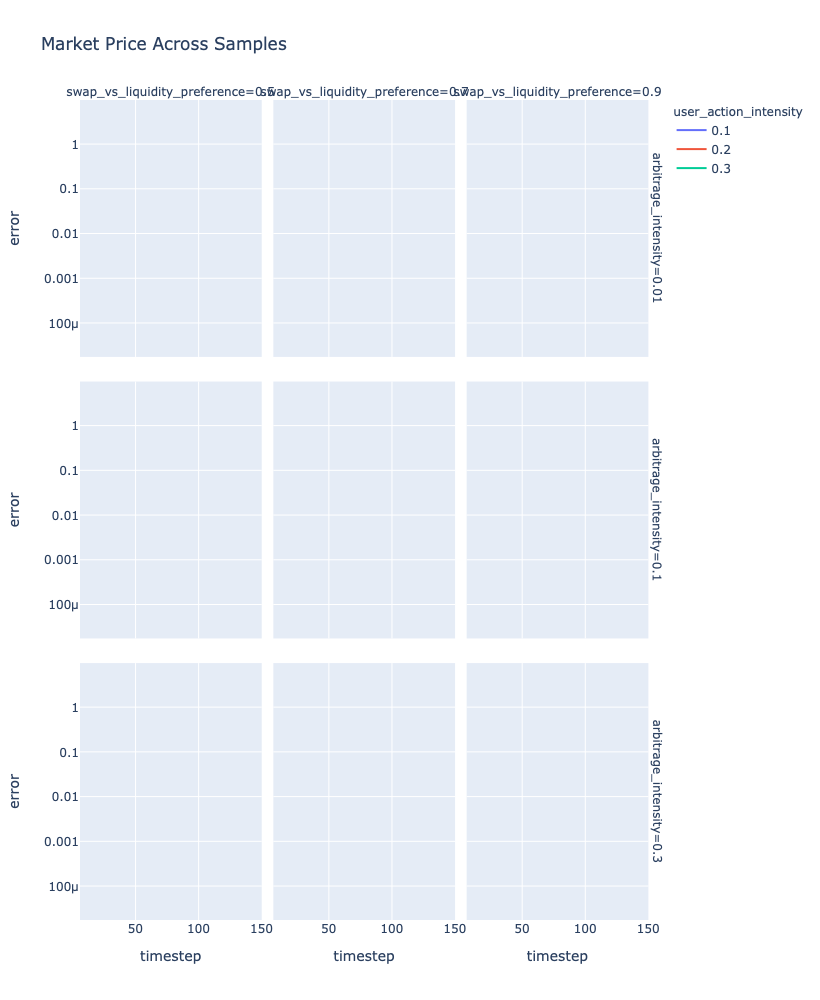

time: 360 ms (started: 2021-05-10 17:50:47 -03:00)


In [8]:
fig_df = df.query('timestep > 5')

fig = px.line(fig_df,
              x='timestep',
              y='error',
              line_group='run',
              facet_row='arbitrage_intensity',
              facet_col='swap_vs_liquidity_preference',
              color='user_action_intensity',
              #color='positive_direction_bias',
              width=1000,
              height=1000,
              log_y=True,
              title='Market Price Across Samples')
fig.show()

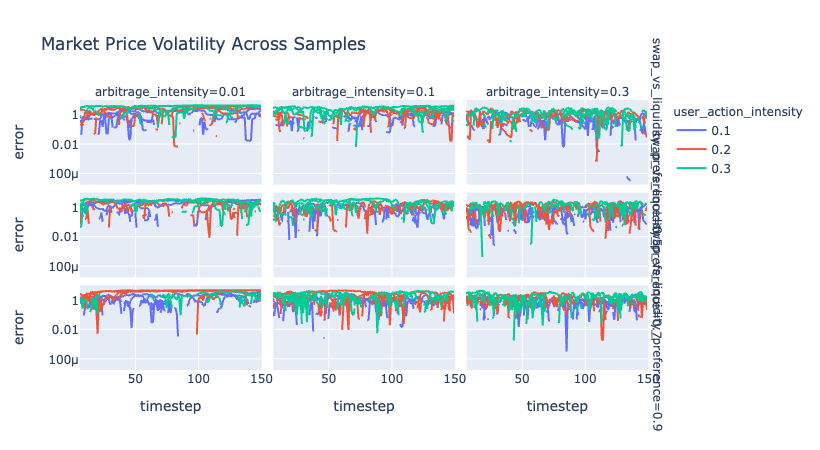

time: 388 ms (started: 2021-05-10 17:50:47 -03:00)


In [9]:
fig_df = df.query('timestep > 5')

fig = px.line(fig_df,
              x='timestep',
              y='error',
              line_group='run',
              facet_col='arbitrage_intensity',
              facet_row='swap_vs_liquidity_preference',
              color='user_action_intensity',
              log_y=True,
              title='Market Price Volatility Across Samples')
fig.show()

In [10]:
from cadcad_machine_search.visualizations import kpi_sensitivity_plot
from interacting_amm_model.kpis import KPIs, SYSTEM_GOALS

time: 1.04 s (started: 2021-05-10 17:50:48 -03:00)


In [11]:
print(KPIs.keys())

dict_keys(['price_volatility', 'price_integral_error', 'slippage_magnitude', 'slippage_volatility', 'immediate_yield', 'integral_yield'])
time: 346 µs (started: 2021-05-10 17:50:49 -03:00)


In [12]:
g_df = df.groupby(['simulation', 'run', 'subset'])

KPI_THRESHOLDS = {kpi: g_df.apply(kpi_f).median()
                  for kpi, kpi_f in KPIs.items()}

def f(kpi, kpi_f):
    def g(df):
        return KPI_THRESHOLDS[kpi] > kpi_f(df)
    return g

KPI_CLASSIFIERS = {kpi: f(kpi, kpi_f)
                   for kpi, kpi_f in KPIs.items()}

time: 757 ms (started: 2021-05-10 17:50:49 -03:00)


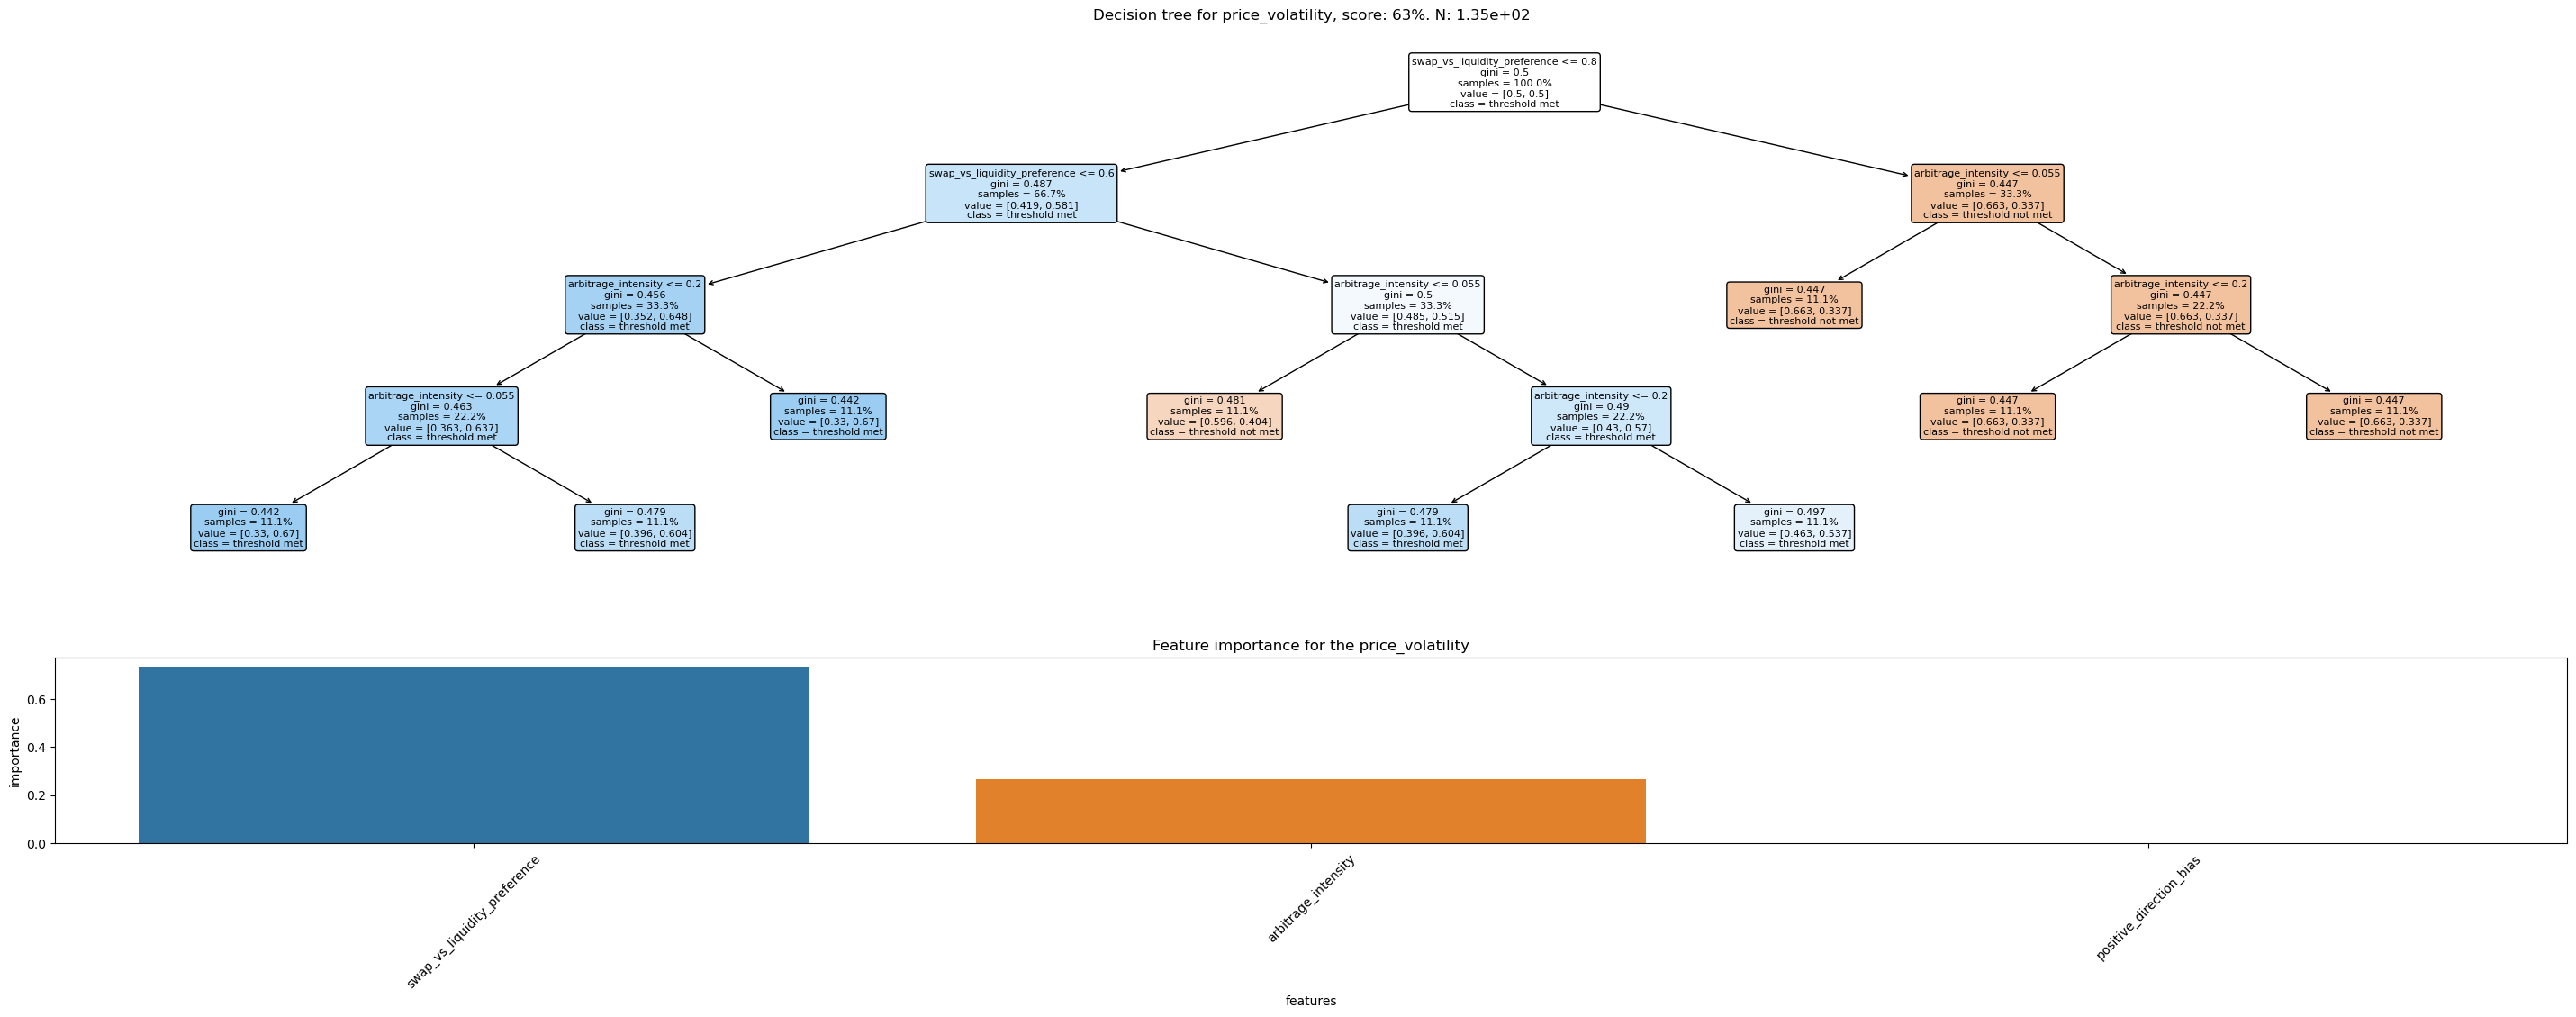

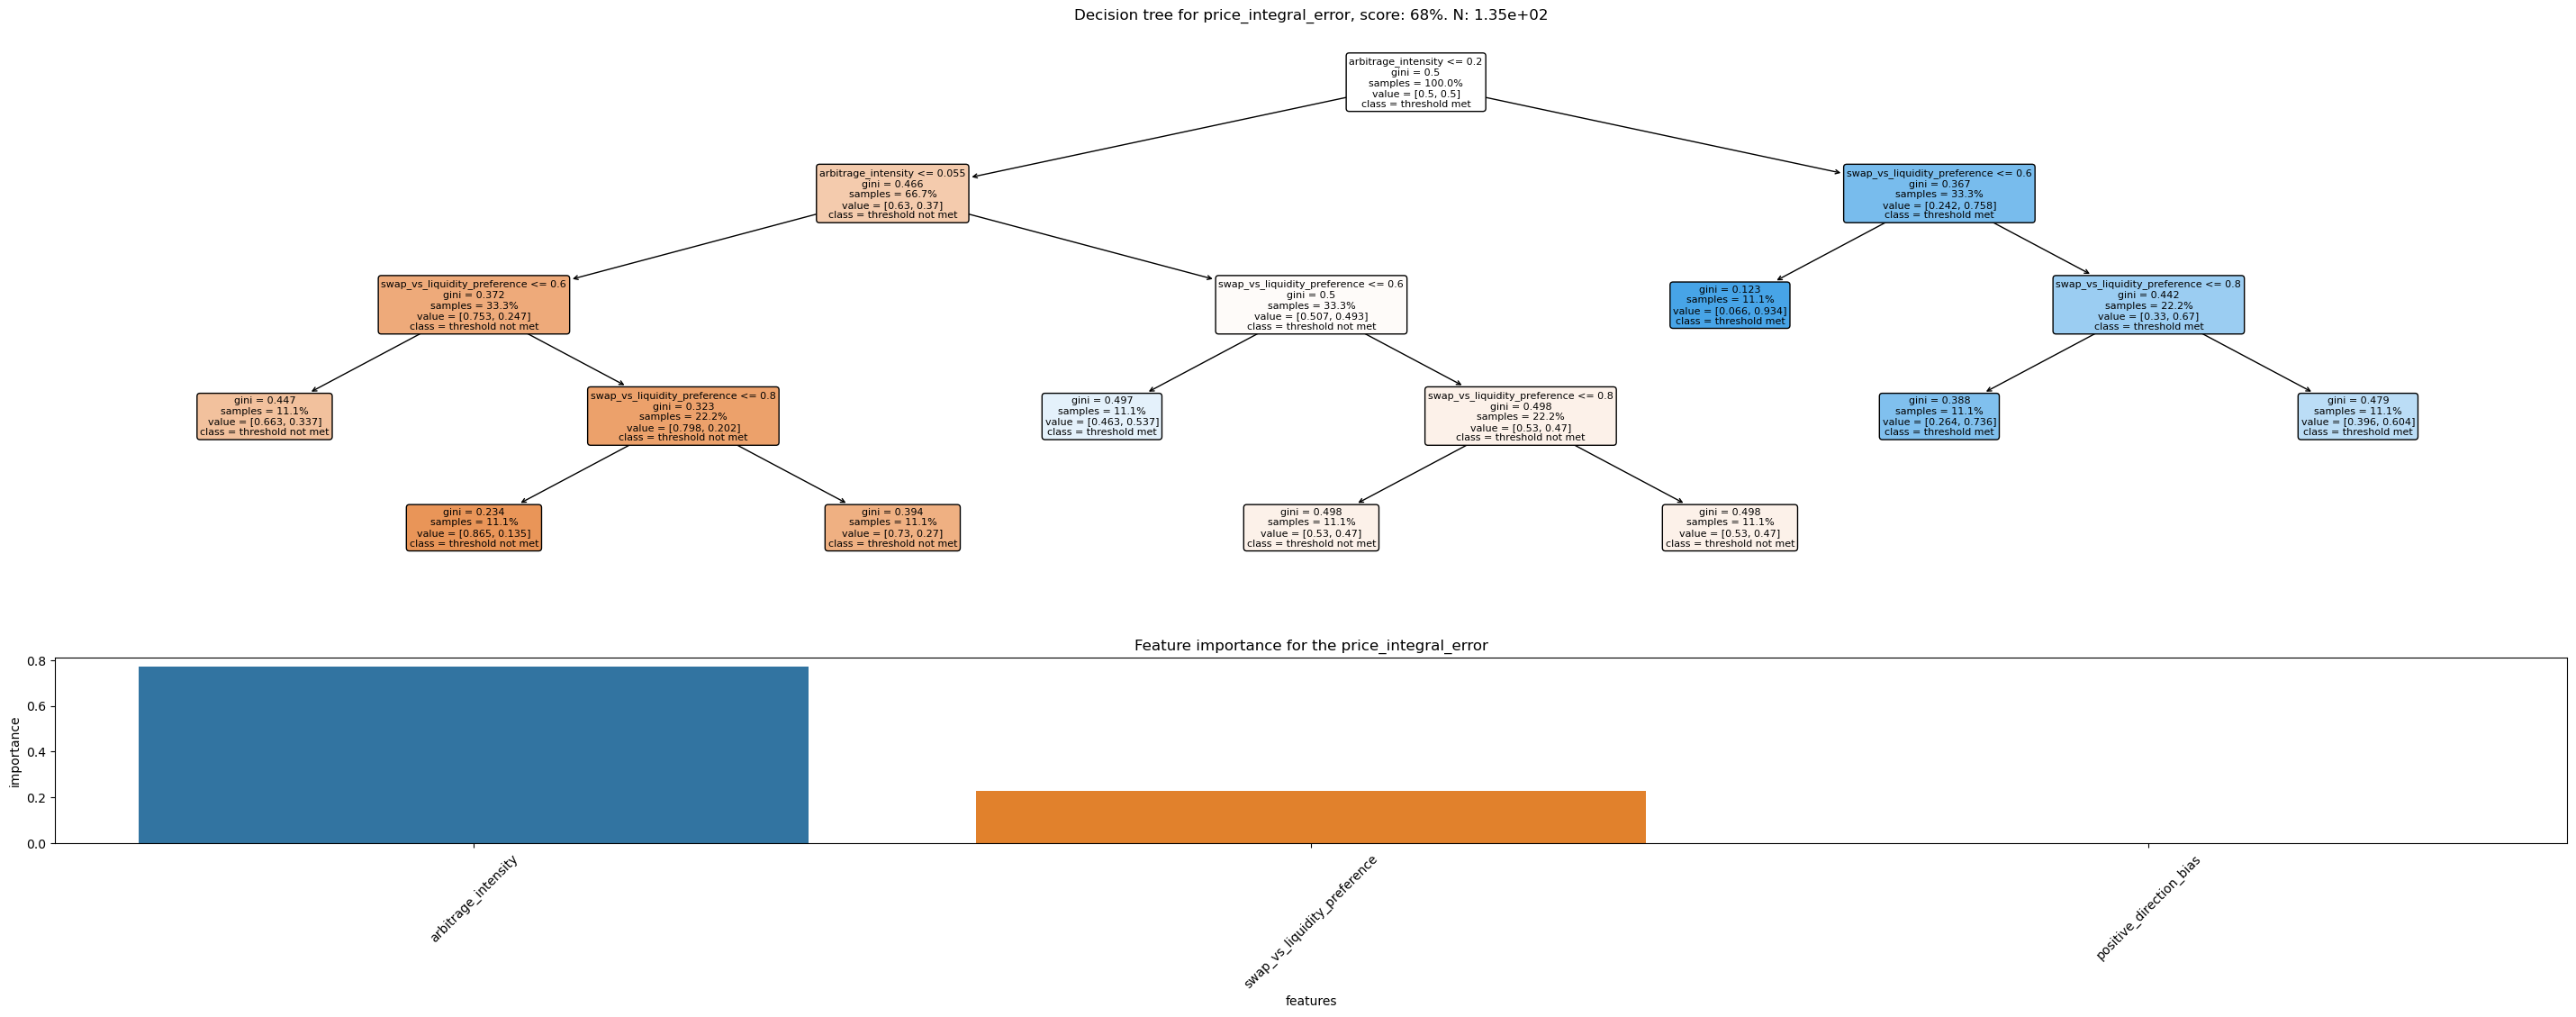

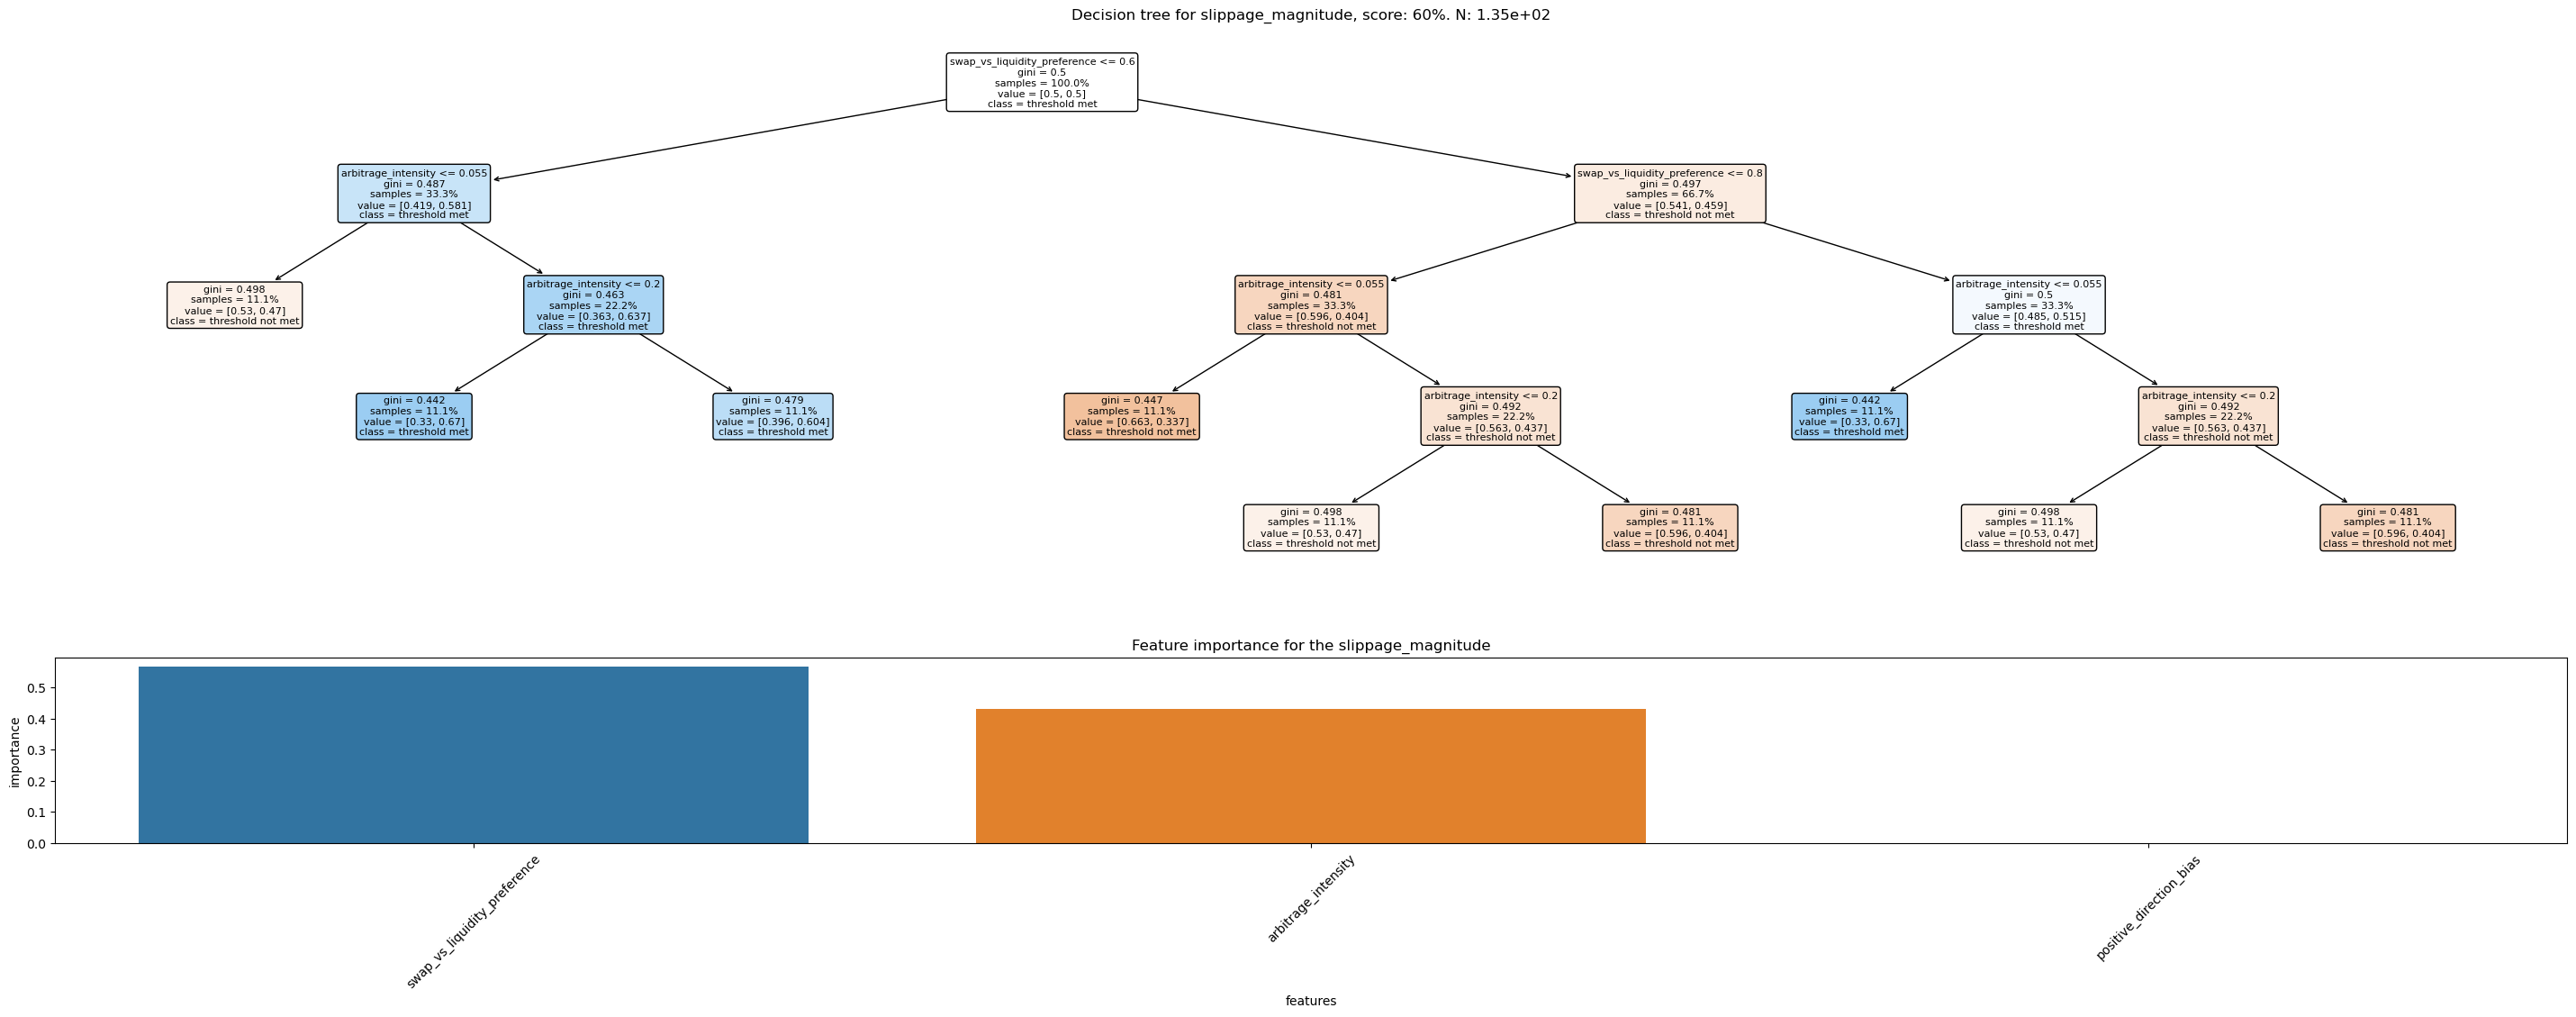

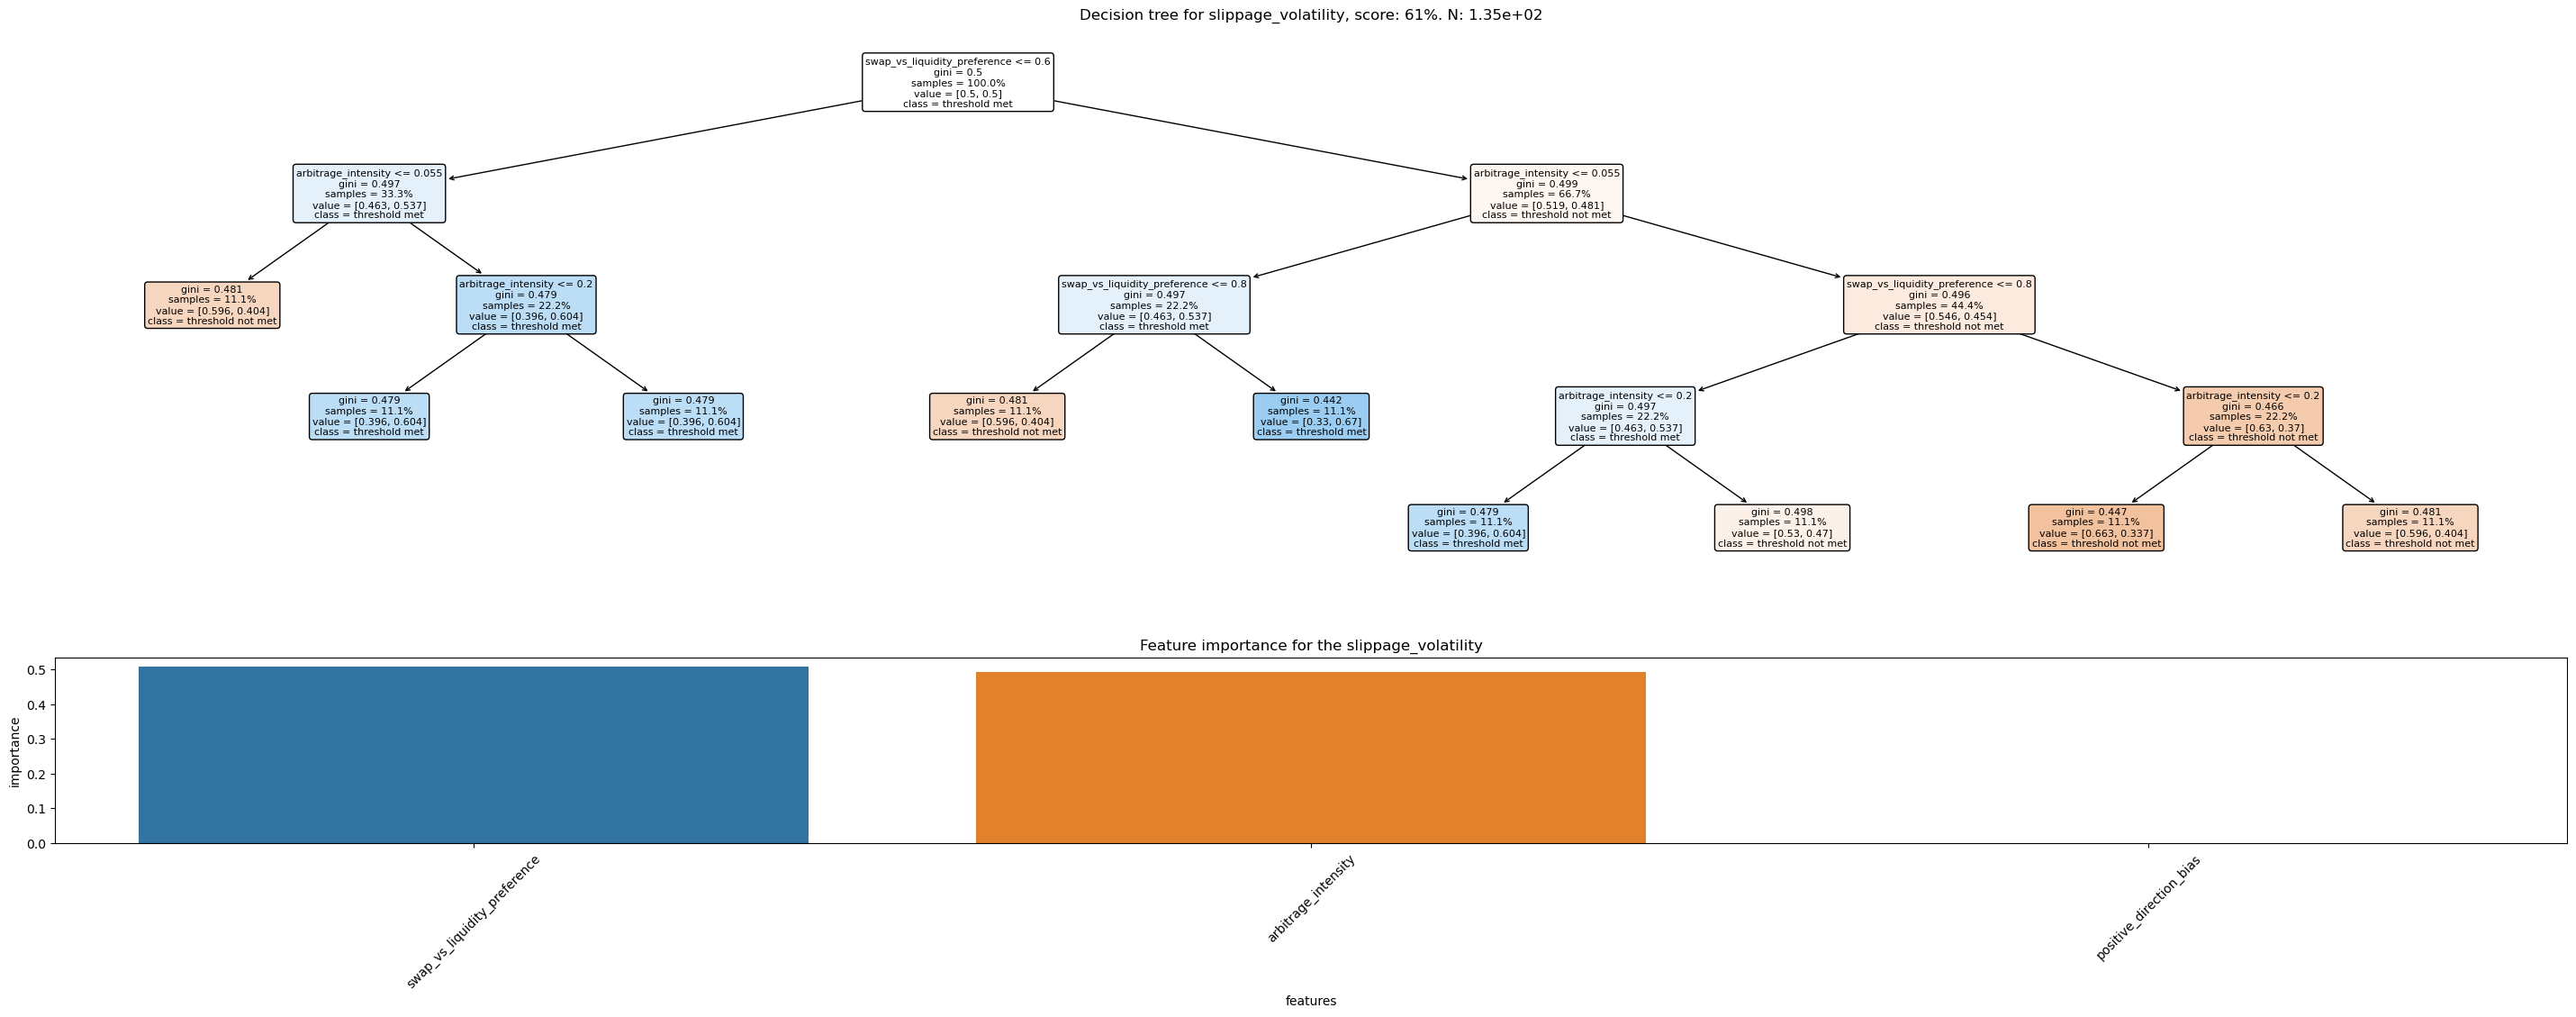

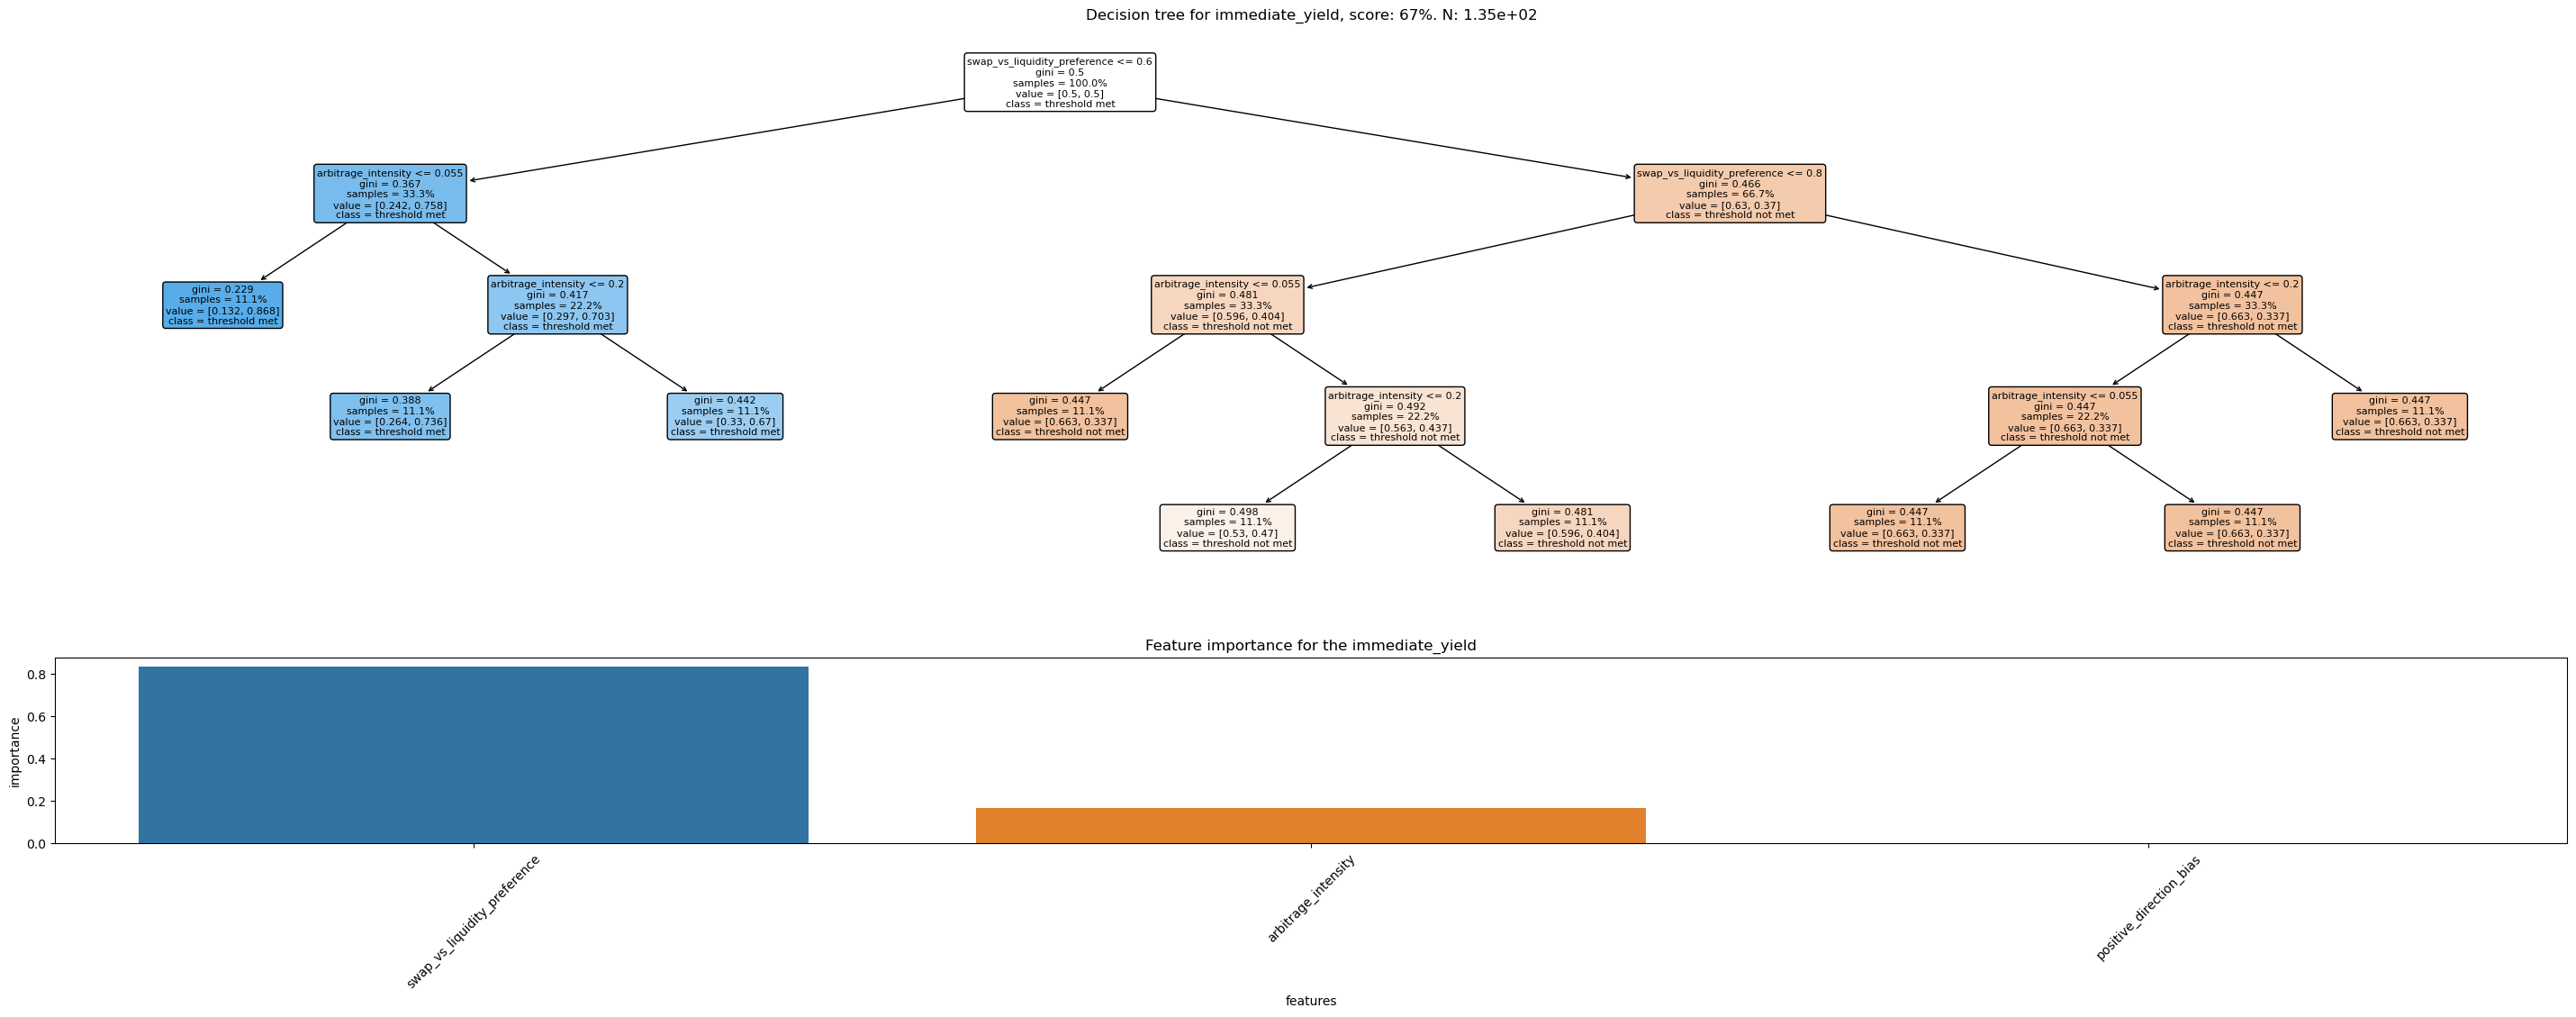

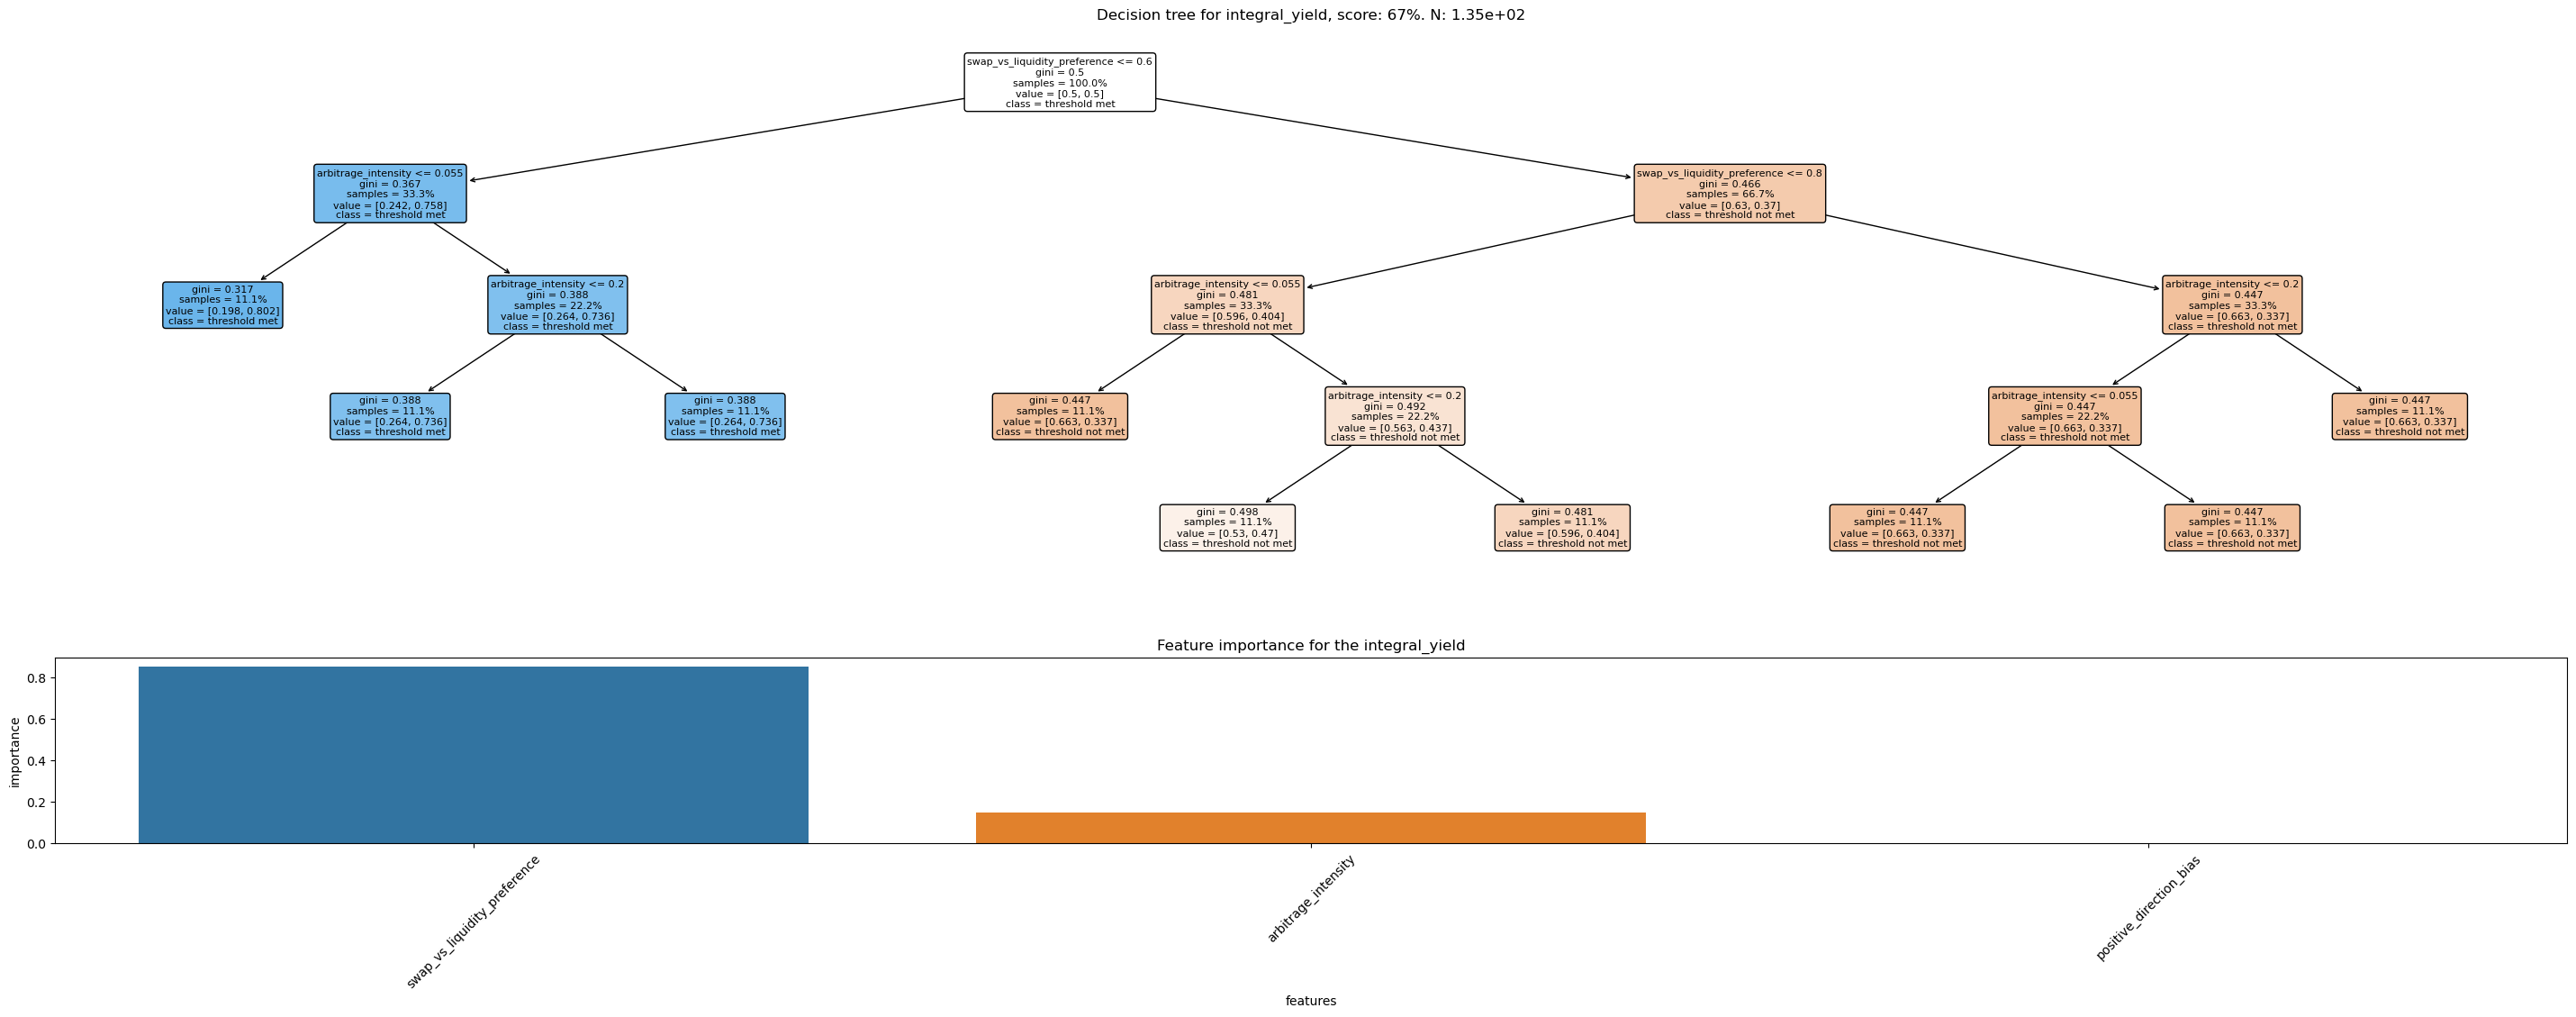

time: 3.62 s (started: 2021-05-10 17:51:18 -03:00)


In [17]:
for kpi_label, kpi in KPI_CLASSIFIERS.items():
    kpi_sensitivity_plot(df,
                        kpi, 
                        sweep_params - {'user_action_intensity'},
                        kpi_label)

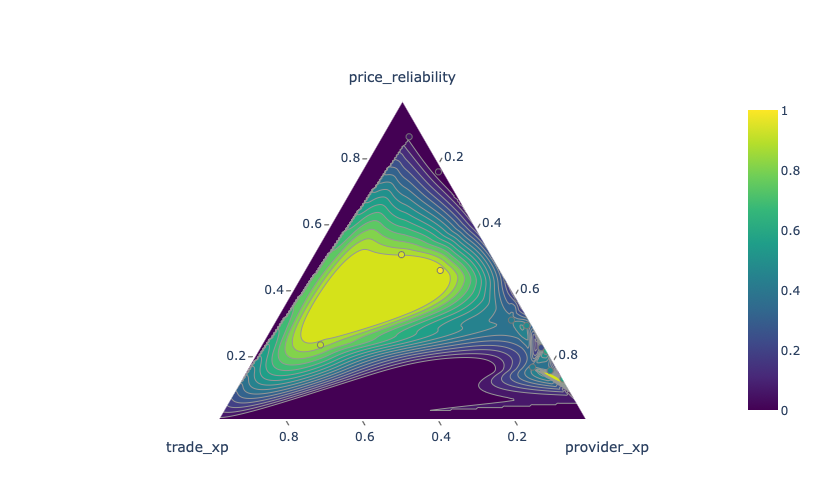

time: 312 ms (started: 2021-05-10 17:50:54 -03:00)


In [14]:
from cadcad_machine_search.visualizations import plot_goal_ternary

plot_goal_ternary(df, KPIs, SYSTEM_GOALS, sweep_params)
